<h1>CREAZIONE MODELLO SARIMA REGIONE LAZIO

In [161]:
import pandas as pd
df = pd.read_csv('../../csv/regioni/lazio.csv')
df.head()

,DATA,TOTALE
0,2015-01-31,5844
1,2015-02-28,5079
2,2015-03-31,5081
3,2015-04-30,4535
4,2015-05-31,4212


In [162]:
df['DATA'] = pd.to_datetime(df['DATA'])

In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATA    66 non-null     datetime64[ns]
 1   TOTALE  66 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.2 KB


In [164]:
df=df.set_index('DATA')
df.head()

,TOTALE
DATA,
2015-01-31,5844
2015-02-28,5079
2015-03-31,5081
2015-04-30,4535
2015-05-31,4212


<h3>Creazione serie storica dei decessi totali della regione Lazio

In [165]:
ts = df.TOTALE
ts.head()

DATA
2015-01-31    5844
2015-02-28    5079
2015-03-31    5081
2015-04-30    4535
2015-05-31    4212
Name: TOTALE, dtype: int64

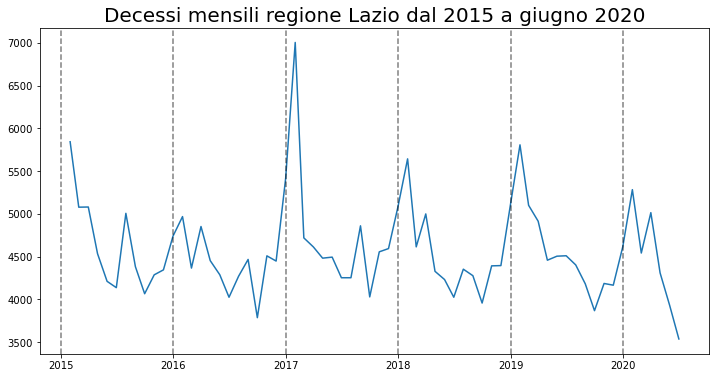

In [166]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(2015,1,1)
end_date = datetime(2020,6,30)
lim_ts = ts[start_date:end_date]

#visulizzo il grafico
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title('Decessi mensili regione Lazio dal 2015 a giugno 2020', size=20)
plt.plot(lim_ts)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)

In [170]:
df = df.reset_index()
df = df[df['DATA'] > '2017-01-31']
df=df.set_index('DATA')
df.head()

,TOTALE
DATA,
2017-02-28,4720
2017-03-31,4614
2017-04-30,4483
2017-05-31,4495
2017-06-30,4254


In [171]:
ts = df.TOTALE
ts.head()

DATA
2017-02-28    4720
2017-03-31    4614
2017-04-30    4483
2017-05-31    4495
2017-06-30    4254
Name: TOTALE, dtype: int64

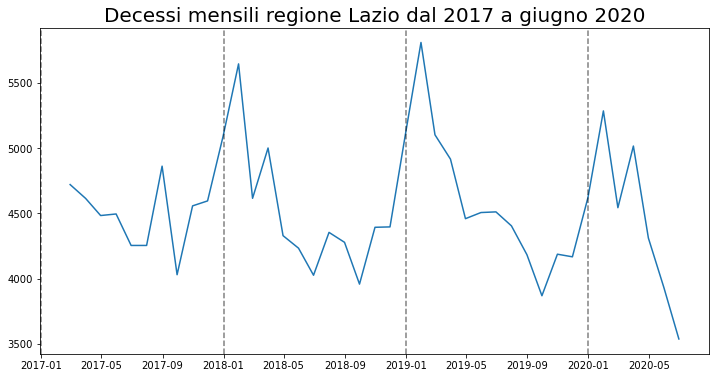

In [172]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(2017,1,31)
end_date = datetime(2020,6,30)
lim_ts = ts[start_date:end_date]

#visulizzo il grafico
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title('Decessi mensili regione Lazio dal 2017 a giugno 2020', size=20)
plt.plot(lim_ts)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)

<h3>Test di stazionarietà

In [173]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=365).mean()
    rolstd = timeseries.rolling(window=365).std()
    #Plot rolling statistics:
    plt.figure(figsize=(10,5))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
        return True
    else:
        print("X is not stationary")
        return False
        

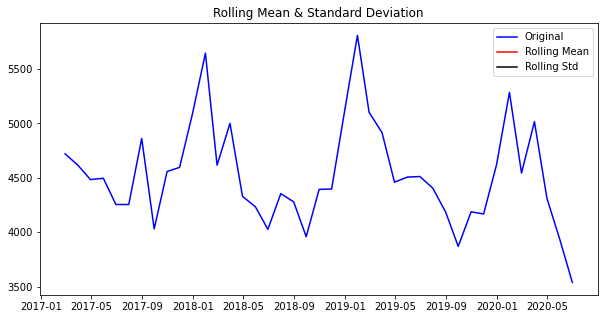

Results of Dickey-Fuller Test:
Test Statistic                 -3.185343
p-value                         0.020849
#Lags Used                      0.000000
Number of Observations Used    40.000000
Critical Value (1%)            -3.605565
Critical Value (5%)            -2.937069
Critical Value (10%)           -2.606986
dtype: float64
X is not stationary


False

In [174]:
test_stationarity(ts)

In [175]:
ts_diff = ts.diff()
ts_diff.fillna(0, inplace=True)

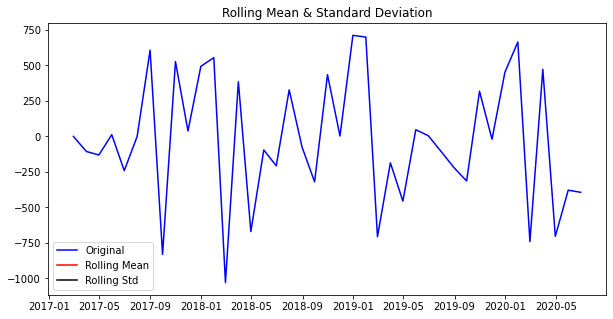

Results of Dickey-Fuller Test:
Test Statistic                 -4.197535
p-value                         0.000665
#Lags Used                     10.000000
Number of Observations Used    30.000000
Critical Value (1%)            -3.669920
Critical Value (5%)            -2.964071
Critical Value (10%)           -2.621171
dtype: float64
X is stationary


True

In [176]:
test_stationarity(ts_diff)

<h3>Decomposizione

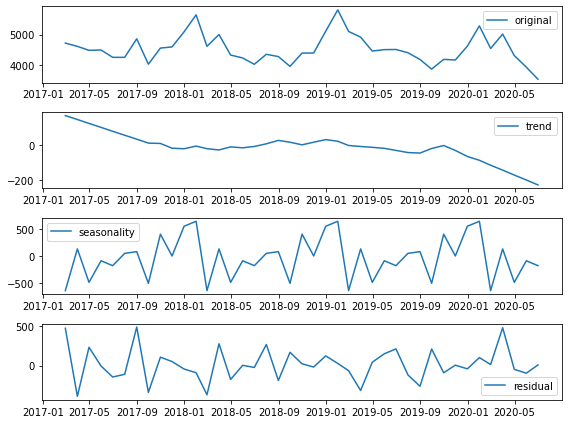

In [177]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_diff, period=12, two_sided=True, extrapolate_trend=1, model='additive')

ts_trend = decomposition.trend #andamento della curva
ts_seasonal = decomposition.seasonal #stagionalità 
ts_residual = decomposition.resid #parti rimanenti
plt.figure(figsize=(8,6))
plt.subplot(411)
plt.plot(ts,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_seasonal,label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_residual,label='residual')
plt.legend(loc='best')
plt.tight_layout()

<h3>Suddivisione in Train e Test

<b>Train</b>: da gennaio 2015 a ottobre 2019; <br />
<b>Test</b>: da ottobre 2019 a dicembre 2019.

In [178]:
from datetime import datetime
train_end = datetime(2019,10,31)
test_end = datetime (2019,12,31)
covid_end = datetime(2020,6,30)

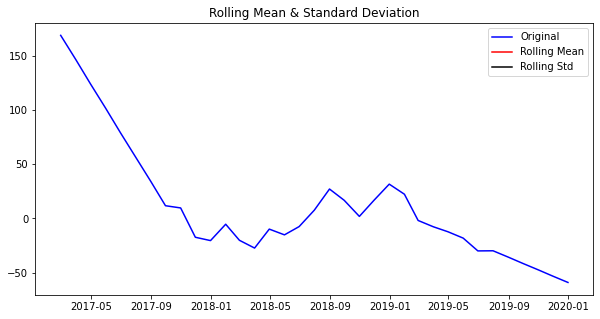

Results of Dickey-Fuller Test:
Test Statistic                 -2.104261
p-value                         0.242805
#Lags Used                      3.000000
Number of Observations Used    31.000000
Critical Value (1%)            -3.661429
Critical Value (5%)            -2.960525
Critical Value (10%)           -2.619319
dtype: float64
X is not stationary


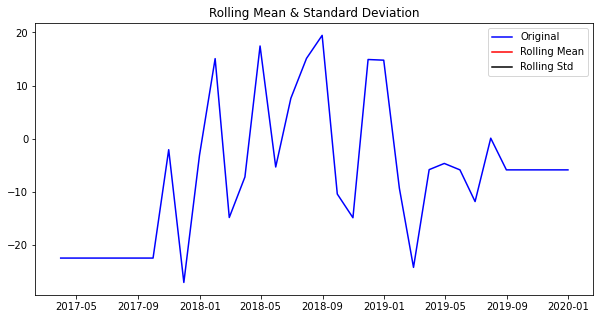

Results of Dickey-Fuller Test:
Test Statistic                 -2.051597
p-value                         0.264417
#Lags Used                      2.000000
Number of Observations Used    31.000000
Critical Value (1%)            -3.661429
Critical Value (5%)            -2.960525
Critical Value (10%)           -2.619319
dtype: float64
X is not stationary


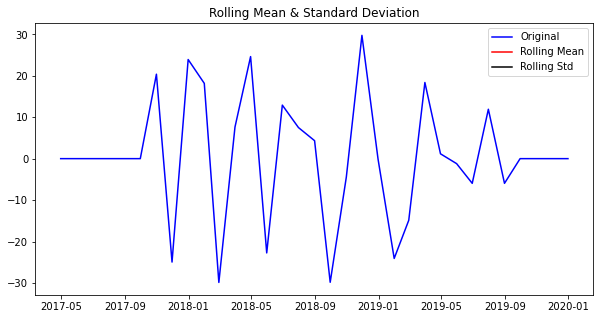

Results of Dickey-Fuller Test:
Test Statistic                -5.756321e+00
p-value                        5.808584e-07
#Lags Used                     2.000000e+00
Number of Observations Used    3.000000e+01
Critical Value (1%)           -3.669920e+00
Critical Value (5%)           -2.964071e+00
Critical Value (10%)          -2.621171e+00
dtype: float64
X is stationary
2


In [179]:
from dateutil.relativedelta import *
tsb = ts_diff[:test_end]
decomposition = seasonal_decompose(tsb, period=12, two_sided=True, extrapolate_trend=1, model='additive')

tsb_trend = decomposition.trend #andamento della curva
tsb_seasonal = decomposition.seasonal #stagionalità 
tsb_residual = decomposition.resid #parti rimanenti


tsb_diff = pd.Series(tsb_trend)
d = 0
while test_stationarity(tsb_diff) is False:
    tsb_diff = tsb_diff.diff().dropna()
    d = d + 1
print(d)

#TEST: dal 01-01-2015 al 31-10-2019
train = tsb[:train_end]

#TRAIN: dal 01-11-2019 al 31-12-2019
test = tsb[train_end + relativedelta(months=+1): test_end]

<h3>Grafici di Autocorrelazione e Autocorrelazione Parziale

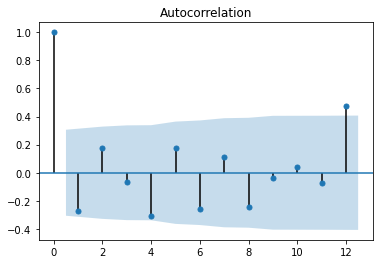

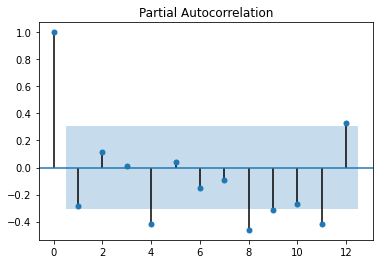

In [197]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_diff, lags =12)
plot_pacf(ts_diff, lags =12)
plt.show()

<h2>Creazione del modello SARIMA sul Train

In [236]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train, order=(12,1,12))
model_fit = model.fit()
print(model_fit.summary())

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                               SARIMAX Results                                
Dep. Variable:                 TOTALE   No. Observations:                   33
Model:             SARIMAX(12, 1, 12)   Log Likelihood                -240.592
Date:                Sun, 15 Nov 2020   AIC                            531.183
Time:                        21:04:30   BIC                            567.826
Sample:                    02-28-2017   HQIC                           543.329
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6871    341.943     -0.002      0.998    -670.883     669.509
ar.L2         -0.6763    278.375     -0.002      0.998    -546.282     544.929
ar.L3         -0.8410    215.977     -0.004      0.9

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<h4>Verifica della stazionarietà dei residui del modello ottenuto

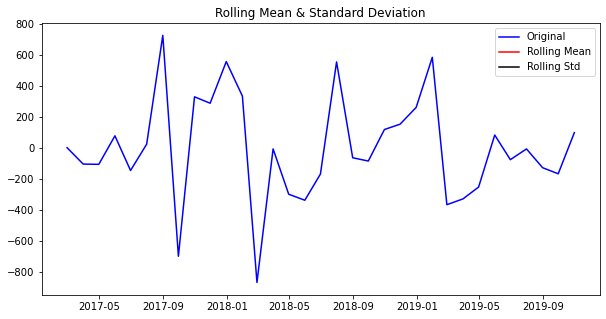

Results of Dickey-Fuller Test:
Test Statistic                -6.032192e+00
p-value                        1.409314e-07
#Lags Used                     0.000000e+00
Number of Observations Used    3.200000e+01
Critical Value (1%)           -3.653520e+00
Critical Value (5%)           -2.957219e+00
Critical Value (10%)          -2.617588e+00
dtype: float64
X is stationary


True

In [237]:
residuals = model_fit.resid
test_stationarity(residuals)

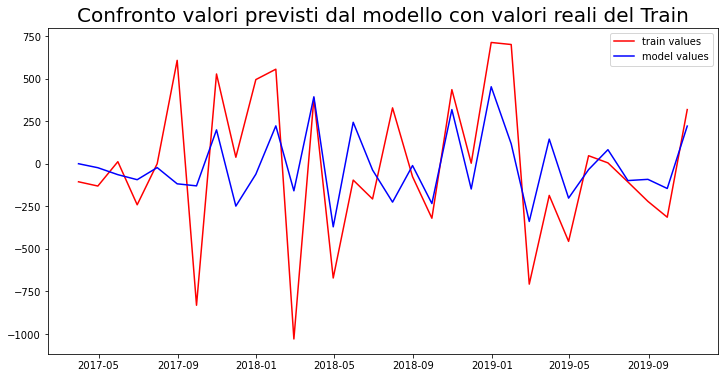

In [238]:
plt.figure(figsize=(12,6))
plt.title('Confronto valori previsti dal modello con valori reali del Train', size=20)
plt.plot (train.iloc[1:], color='red', label='train values')
plt.plot (model_fit.fittedvalues.iloc[1:], color = 'blue', label='model values')

plt.legend()
plt.show()

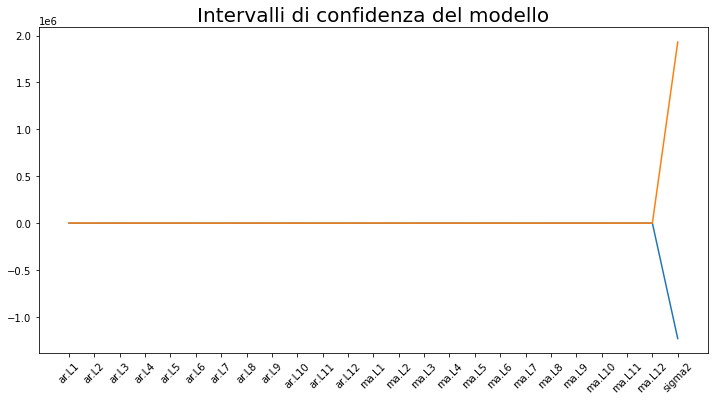

In [239]:
conf = model_fit.conf_int()

plt.figure(figsize=(12,6))
plt.title('Intervalli di confidenza del modello', size=20)
plt.plot(conf)
plt.xticks(rotation=45)
plt.show()

<h3>Predizione del modello sul Test

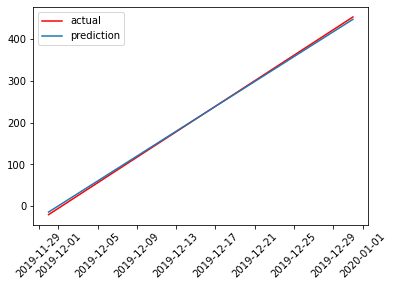

2019-11-30    -13.851132
2019-12-31    446.412721
Freq: M, Name: predicted_mean, dtype: float64


In [240]:
#inizio e fine predizione
pred_start = test.index[0]
pred_end = test.index[-1]

#pred_start= len(train)
#pred_end = len(tsb)
#predizione del modello sul test
predictions_test= model_fit.predict(start=pred_start, end=pred_end)

plt.plot(test, color='red', label='actual')
plt.plot(predictions_test, label='prediction' )
plt.xticks(rotation=45)
plt.legend()
plt.show()

print(predictions_test)

<h3>Calcolo dell'indice RMSE

In [241]:
import numpy as np
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(predictions_test, test)/(np.max(test)-np.min(test))
print('RMSE = ', nrmse)

RMSE =  0.012446584158230165


<h2>Predizione del modello compreso l'anno 2020

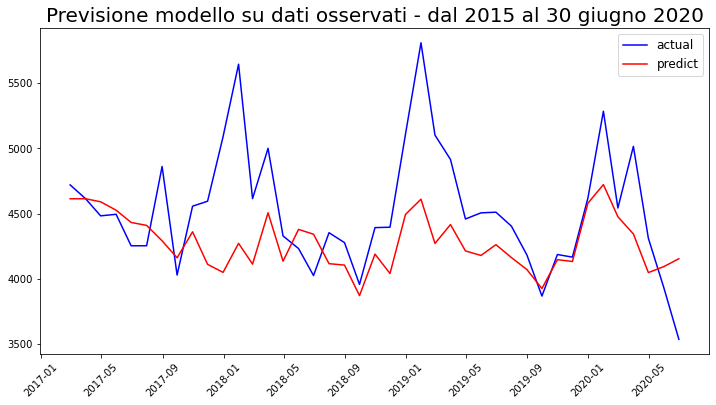

In [242]:
#inizio e fine predizione
start_prediction = ts_diff.index[0]
end_prediction = ts_diff.index[-1]

predictions = model_fit.predict(start=start_prediction, end=end_prediction)

predictions_tot = predictions.cumsum()+ts.iloc[1]

plt.figure(figsize=(12,6))
plt.title('Previsione modello su dati osservati - dal 2015 al 30 giugno 2020', size=20)
plt.plot(ts, color='blue', label='actual')
plt.plot(predictions_tot, color='red', label='predict')
plt.xticks(rotation=45)
plt.legend(prop={'size': 12})
plt.show()

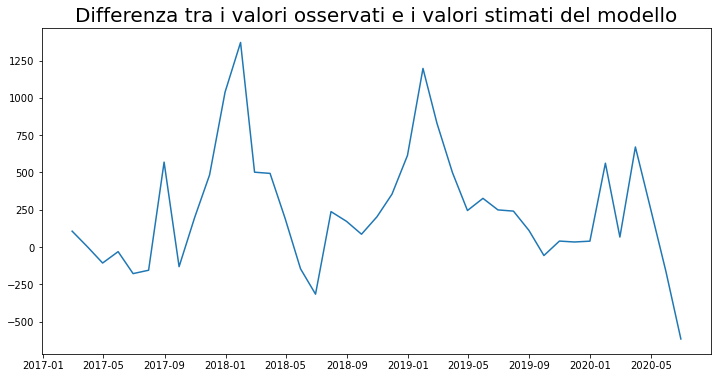

In [243]:
diff_predictions_tot = (ts - predictions_tot)
plt.figure(figsize=(12,6))
plt.title('Differenza tra i valori osservati e i valori stimati del modello', size=20)
plt.plot(diff_predictions_tot)
plt.show()

In [244]:
diff_predictions_tot['24-02-2020':].sum()

220.20685297642376

In [245]:
predictions_tot.to_csv('../../csv/pred/predictions_SARIMA_lazio.csv')

<h2>Intervalli di confidenza della previsione totale

In [246]:
forecast = model_fit.get_prediction(start=start_prediction, end=end_prediction)
in_c = forecast.conf_int()
print(forecast.predicted_mean)
print(in_c)
print(forecast.predicted_mean - in_c['lower TOTALE'])

2017-02-28      0.000000
2017-03-31      0.000000
2017-04-30    -23.442508
2017-05-31    -64.227178
2017-06-30    -93.747904
2017-07-31    -22.643670
2017-08-31   -117.968319
2017-09-30   -130.014525
2017-10-31    198.823586
2017-11-30   -248.860082
2017-12-31    -61.587774
2018-01-31    222.234116
2018-02-28   -159.034710
2018-03-31    392.986556
2018-04-30   -370.529714
2018-05-31    243.328125
2018-06-30    -36.932590
2018-07-31   -225.470034
2018-08-31    -10.823699
2018-09-30   -233.658247
2018-10-31    317.722955
2018-11-30   -148.415065
2018-12-31    452.024357
2019-01-31    116.804206
2019-02-28   -338.907579
2019-03-31    144.668064
2019-04-30   -201.864687
2019-05-31    -34.533830
2019-06-30     82.463594
2019-07-31    -98.886343
2019-08-31    -91.727616
2019-09-30   -145.397173
2019-10-31    221.073225
2019-11-30    -13.851132
2019-12-31    446.412721
2020-01-31    142.169469
2020-02-29   -245.839849
2020-03-31   -131.963396
2020-04-30   -295.753468
2020-05-31     45.887062


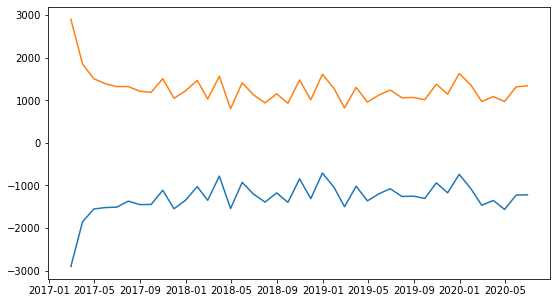

In [247]:
plt.figure(figsize=(9,5))
plt.plot(in_c)
plt.show()

In [248]:
upper = in_c['upper TOTALE']
lower = in_c['lower TOTALE']

In [249]:
lower.to_csv('../../csv/lower/predictions_SARIMA_lazio_lower.csv')
upper.to_csv('../../csv/upper/predictions_SARIMA_lazio_upper.csv')